In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./..")

In [3]:
import numpy as np
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision
import torch.nn as nn
from torch import optim
#
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import tqdm
#

from misc.plot_utils import plot_mat, imshow
from effcn.layers import FCCaps, FCCapsWOBias, Squash
from effcn.utils import count_parameters
from effcn.functions import margin_loss

In [4]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)

In [5]:
#!pip install einops

In [6]:
ds_train = datasets.MNIST(
    root = '/mnt/data/pytorch',
    train = True,                         
    transform = T.ToTensor(), 
    download = True,            
)
ds_test = datasets.MNIST(
    root = '/mnt/data/pytorch',
    train = False, 
    transform = T.ToTensor()
)
dl_train = DataLoader(ds_train, batch_size=2, shuffle=False)

In [7]:
transform_train = T.Compose([
    T.RandomRotation(degrees=(-30, 30)),
    T.RandomResizedCrop(
        28,
        scale=(0.8, 1.0),
        ratio=(1, 1),
    ),
    T.RandomAffine(
        degrees=(-30, 30),
        #translate=(0.1, 0.1)
    ),
    T.ToTensor()
])
transform_valid = T.Compose([
    T.ToTensor()
])

In [8]:
ds_train = datasets.MNIST(root='./../data', train=True, download=True, transform=transform_train)
ds_valid = datasets.MNIST(root="./../data", train=False, download=True, transform=transform_valid)
#
dl_train = torch.utils.data.DataLoader(ds_train, 
                                       batch_size=512, 
                                       shuffle=True, 
                                       num_workers=4)
dl_valid = torch.utils.data.DataLoader(ds_valid, 
                                       batch_size=512, 
                                       shuffle=True, 
                                       num_workers=4)

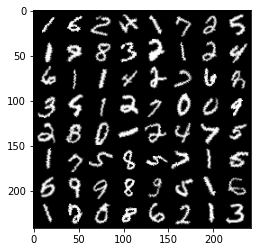

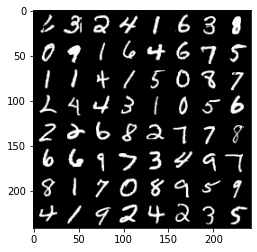

In [9]:
# plot train imgs
x, y = next(iter(dl_train))
img = torchvision.utils.make_grid(x[:64], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

# plot valid imgs
x, y = next(iter(dl_valid))
img = torchvision.utils.make_grid(x[:64], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

In [105]:
class VisualCapsules(nn.Module):
    """
        Add Dropout ?
    """
    def __init__(self, h, w, c, patch_hw, d_out):
        super().__init__()
        self.h = h                    # img height
        self.w = w                    # img width
        self.c = c                    # img channels
        self.d_out = d_out            # embedding dim
        self.patch_hw = patch_hw      # patch size = patch_h, patch_w
        
        self.n_patches = h//patch_hw * w//patch_hw  # = #capsules
        self.n_caps = self.n_patches
        
        # make sure it adds up
        self.d_patch = patch_hw**2 * c 
        assert self.n_patches * self.d_patch == h * w * c

        self.pos_emb = nn.Parameter(
            torch.rand(1, self.n_patches, d_out),
            requires_grad=True
        )
        self.patch_emb = nn.Sequential(
            nn.Linear(self.d_patch, self.d_out),
        )
        self.head = nn.Sequential(
            #nn.Linear(self.d_out, 32),
            #nn.ReLU(),
            #nn.Linear(32, 32),
            #nn.ReLU(),
            #nn.Linear(32, self.d_out),
            Squash(eps=1e-20)
        )
        self.emb_dropout = nn.Dropout(0.1)
    def forward(self, x):
        """
            in:  x (b, c, h, w)
            out: (b, patch_hw, d)
        """
        batch_size = x.shape[0]
        x = rearrange(
            x, 'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                                patch_x=self.patch_hw, patch_y=self.patch_hw)
        x = self.patch_emb(x)
        x = x + self.pos_emb
        x = self.emb_dropout(x)
        x = self.head(x)
        return x
    
class CapsOnly3L(nn.Module):
    def __init__(self, h, w, c, patch_hw, dim, n_pc, n_dc):
        super().__init__()
        self.caps_visual = VisualCapsules(h,w,c,patch_hw,dim)
        self.caps_parts = FCCapsWOBias(n_l=self.caps_visual.n_caps, n_h=n_pc, d_l=dim, d_h=dim)
        self.caps_digits = FCCapsWOBias(n_l=n_pc, n_h=n_dc, d_l=dim, d_h=dim)
    
    def forward(self, x):
        x = self.caps_visual(x)
        x = self.caps_parts(x)
        x = self.caps_digits(x)
        return x
    
class CapsOnly2L(nn.Module):
    def __init__(self, h, w, c, patch_hw, dim, n_dc):
        super().__init__()
        self.caps_visual = VisualCapsules(h,w,c,patch_hw,dim)
        self.caps_digits = FCCapsWOBias(n_l=self.caps_visual.n_caps, n_h=n_dc, d_l=dim, d_h=dim)
    
    def forward(self, x):
        x = self.caps_visual(x)
        x = self.caps_digits(x)
        return x

In [111]:
d = 16
patch_hw = 7
n_pc = 16
n_dc = 10

model = CapsOnly3L(28, 28, 1, patch_hw=patch_hw, dim=d, n_pc=n_pc, n_dc=n_dc)
#model = CapsOnly2L(28, 28, 1, patch_hw=patch_hw, dim=d, n_dc=n_dc)
model = model.to(device)
print(count_parameters(model))

107552


In [112]:
model

CapsOnly3L(
  (caps_visual): VisualCapsules(
    (patch_emb): Sequential(
      (0): Linear(in_features=49, out_features=16, bias=True)
    )
    (head): Sequential(
      (0): Squash()
    )
    (emb_dropout): Dropout(p=0.1, inplace=False)
  )
  (caps_parts): FCCapsWOBias(
    (squash): Squash()
  )
  (caps_digits): FCCapsWOBias(
    (squash): Squash()
  )
)

In [113]:
optimizer = optim.Adam(model.parameters(), lr = 5e-4, weight_decay=1e-5)

In [114]:
num_epochs = 16
#
for epoch_idx in range(num_epochs):
    # ####################
    # TRAIN
    # ####################
    model.train()
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    
    for x,y_true in pbar:
        x = x.to(device)
        y_true = y_true.to(device)
        optimizer.zero_grad()
        
        u_h = model.forward(x)
        
        # LOSS
        y_one_hot = F.one_hot(y_true, num_classes=10)
        loss = margin_loss(u_h, y_one_hot)

        loss.backward()
        
        optimizer.step()
        
        y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
        acc = (y_true == y_pred).sum() / y_true.shape[0]
        
        pbar.set_postfix(
                {'loss': loss.item(),
                 'acc': acc.item()
                 }
        )
    #
    # ####################
    # VALID
    # ####################
    if epoch_idx % 5 != 0:
        continue
    
    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            u_h = model.forward(x)
            
            y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   acc_valid: {:.3f}".format(total_correct / total))

Train [  0/ 16]:██████████| 118/118 [00:04<00:00, 27.33it/s, loss=0.523, acc=0.167]                                                          


   acc_valid: 0.113


Train [  1/ 16]:██████████| 118/118 [00:03<00:00, 29.91it/s, loss=0.524, acc=0.0833]                                                         
Train [  2/ 16]:██████████| 118/118 [00:04<00:00, 29.37it/s, loss=0.52, acc=0.156]                                                           
Train [  3/ 16]:██████████| 118/118 [00:03<00:00, 29.95it/s, loss=0.413, acc=0.365]                                                          
Train [  4/ 16]:██████████| 118/118 [00:03<00:00, 29.70it/s, loss=0.357, acc=0.458]                                                          
Train [  5/ 16]:██████████| 118/118 [00:04<00:00, 29.30it/s, loss=0.264, acc=0.698]                                                          


   acc_valid: 0.776


Train [  6/ 16]:██████████| 118/118 [00:04<00:00, 28.92it/s, loss=0.282, acc=0.625]                                                          
Train [  7/ 16]:██████████| 118/118 [00:03<00:00, 29.59it/s, loss=0.215, acc=0.698]                                                          
Train [  8/ 16]:██████████| 118/118 [00:03<00:00, 29.92it/s, loss=0.222, acc=0.677]                                                          
Train [  9/ 16]:██████████| 118/118 [00:04<00:00, 28.35it/s, loss=0.224, acc=0.667]                                                          
Train [ 10/ 16]:██████████| 118/118 [00:03<00:00, 30.30it/s, loss=0.216, acc=0.708]                                                          


   acc_valid: 0.863


Train [ 11/ 16]:██████████| 118/118 [00:03<00:00, 29.59it/s, loss=0.184, acc=0.76]                                                           
Train [ 12/ 16]:██████████| 118/118 [00:04<00:00, 28.94it/s, loss=0.206, acc=0.719]                                                          
Train [ 13/ 16]:██████████| 118/118 [00:04<00:00, 28.85it/s, loss=0.2, acc=0.708]                                                            
Train [ 14/ 16]:██████████| 118/118 [00:04<00:00, 28.85it/s, loss=0.241, acc=0.688]                                                          
Train [ 15/ 16]:██████████| 118/118 [00:03<00:00, 30.49it/s, loss=0.183, acc=0.76]                                                           


   acc_valid: 0.885


# Eval

In [65]:
def imshow(img, cmap="gray", vmin=None, vmax=None):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap=cmap, vmin=None, vmax=None)
    plt.show()

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
    tensor = tensor.cpu()
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    #return grid

In [66]:
model.eval()

CapsOnly3L(
  (caps_visual): VisualCapsules(
    (patch_emb): Sequential(
      (0): Linear(in_features=16, out_features=8, bias=True)
    )
    (head): Sequential(
      (0): Squash()
    )
  )
  (caps_parts): FCCapsWOBias(
    (squash): Squash()
  )
  (caps_digits): FCCapsWOBias(
    (squash): Squash()
  )
)

In [67]:
YY = []
CC = []
UUH = []
UUHSQ = []
UUHFIN = []
UUL = []

for X, Y in dl_valid:
    X = X.to(device)
    X = model.caps_visual(X)
    U_l = model.caps_parts(X)
    U_hat, A, A_scaled, A_sum, C, U_h_fin, U_h_sq = model.caps_digits.forward_debug(U_l)
    
    UUL.append(U_l.detach().cpu().numpy())
    UUH.append(U_hat.detach().cpu().numpy())
    YY.append(Y.numpy())
    CC.append(C.detach().cpu().numpy())
    UUHSQ.append(U_h_sq.detach().cpu())
    UUHFIN.append(U_h_fin.detach().cpu())
YY = np.concatenate(YY)
CC = np.concatenate(CC)
UUHSQ = np.concatenate(UUHSQ)
UUHFIN = np.concatenate(UUHFIN)
UUH = np.concatenate(UUH)
UUL = np.concatenate(UUL)

print(YY.shape)
print(CC.shape)

print("U_l      ", U_l.shape[1:])
print("U_hat    ", U_hat.shape[1:])
print("A        ", A.shape[1:])
print("A_scaled ", A_scaled.shape[1:])
print("A_sum    ", A_sum.shape[1:])
print("C        ", C.shape[1:])
print("U_h_fin  ", U_h_fin.shape[1:])
print("U_h_sq   ", U_h_sq.shape[1:])

(10000,)
(10000, 16, 10)
U_l       torch.Size([16, 8])
U_hat     torch.Size([16, 10, 8])
A         torch.Size([16, 16, 10])
A_scaled  torch.Size([16, 16, 10])
A_sum     torch.Size([16, 10])
C         torch.Size([16, 10])
U_h_fin   torch.Size([10, 8])
U_h_sq    torch.Size([10, 8])


In [68]:
idcs = np.where(YY == 0)
Y = YY[idcs]
C = CC[idcs]
UH = UUH[idcs]
UHS = UUHSQ[idcs]
UHF = UUHFIN[idcs]

####################################################################################################


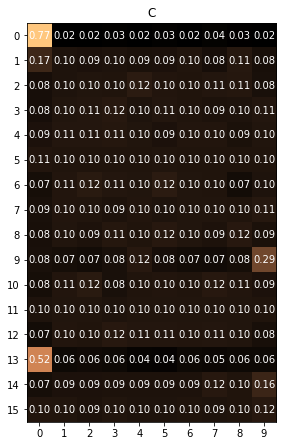

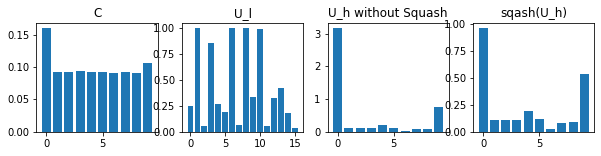

####################################################################################################


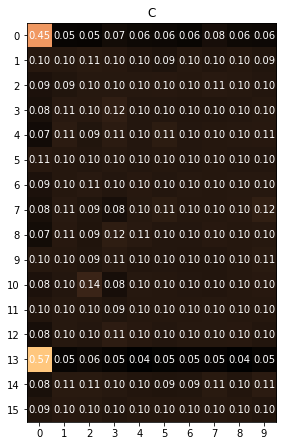

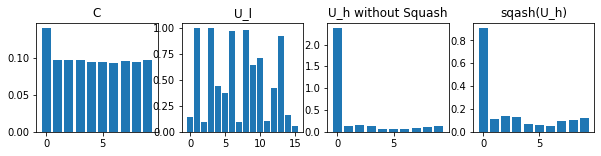

####################################################################################################


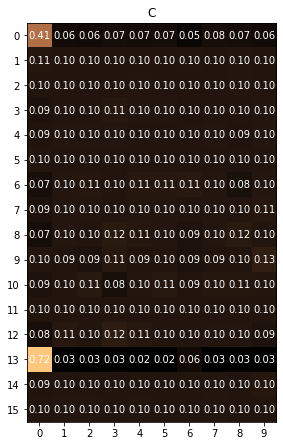

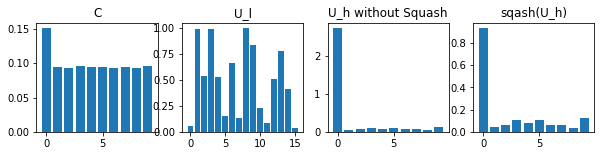

####################################################################################################


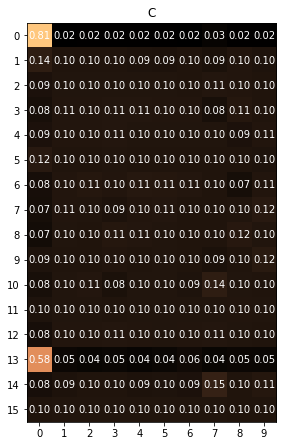

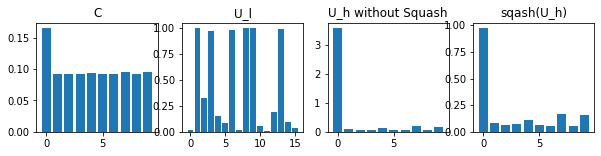

####################################################################################################


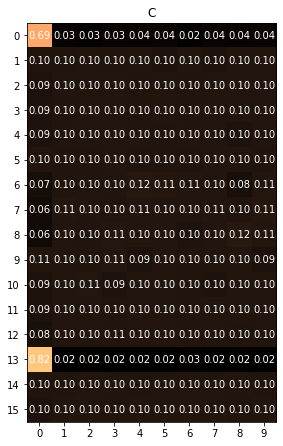

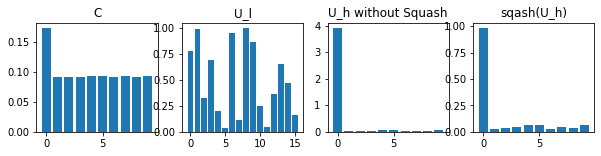

In [69]:
for idx in range(5):
    print("#"*100)
    y = Y[idx]
    c = C[idx]
    uhs = UHS[idx]
    uhf = UHF[idx]
    ul = UUL[idx]
    #plot_mat(ul, scale_factor=0.4, title="U_l = lower level capsules")
    plot_mat(c, scale_factor=0.4, title="C")
    #plot_mat(uhf, scale_factor=0.4, title="U_h, upper layer capsules w/o squash")
    #plot_mat(uhs, scale_factor=0.4, title="squash(U_h)")
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 2))
    axes[0].bar(range(10), c.mean(axis=0))
    axes[0].set_title("C")
    axes[3].bar(range(10), np.linalg.norm(uhs, axis=1))
    axes[3].set_title("sqash(U_h)")
    axes[2].bar(range(10), np.linalg.norm(uhf, axis=1))
    axes[2].set_title("U_h without Squash")
    axes[1].bar(range(ul.shape[0]), np.linalg.norm(ul, axis=1))
    axes[1].set_title("U_l")
    plt.show()

# Positional Embeddings

In [ ]:
n_p = int(np.sqrt(model.caps_visual.n_patches))
all_pe = model.caps_visual.pos_emb.data.detach().cpu()[0]

In [ ]:
all_pe.shape

In [ ]:
pe.repeat_interleave(49).reshape((49, -1))

In [ ]:
pe

In [ ]:
fig, axes = plt.subplots(n_p, n_p, figsize=(10, 10))
for ix in range(n_p):
    for iy in range(n_p):
        ax = axes[ix][iy]
        pe = all_pe[ix * n_p + iy]
        pe = pe.repeat_interleave(49).reshape((49, -1))
        cossim = F.cosine_similarity(pe, all_pe)
        ax.imshow(cossim.reshape((7, 7)), vmin=-1, vmax=1)
plt.show()

In [ ]:
cossim.max()

In [ ]:
cossim.reshape((7, 7))

In [ ]:
pe.shape

In [ ]:
F.cosine_similarity(pe, pe)

In [ ]:
pe.view((7, 7, -1))

In [ ]:
pe.shape